# Removing noise
This tutorial is meant to walk through the use of and theory behind PDAL's `outlier` filter.

- Statistical Outlier Filter
- Radius Outlier Filter

## Statistical Outlier Filter

### Theory
The basic idea of a statistical outlier removal has been implemented in both [PCL](http://www.pointclouds.org/documentation/tutorials/statistical_outlier.php#statistical-outlier-removal) and [PDAL](https://www.pdal.io/stages/filters.outlier.html).

We begin by computing the mean distance $\mu_i$ to each of the $k$ nearest neighbors for each point.

Next, we compute the global mean

$$\overline{\mu} = \frac{1}{N} \sum_{i=1}^N \mu_i$$

and standard deviation

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (\mu_i - \overline{\mu})^2}$$

of the pointwise mean distances.

A threshold is then formed by

$$\overline{\mu} + 3\sigma$$

Any point whose mean distance $\mu_i$ exceeds this threshold is then labeled as noise.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pdal

In [3]:
import seaborn as sns
sns.set(color_codes=True)
sns.set_context("talk")

In [4]:
np.random.seed(sum(map(ord, "aesthetics")))

#### Reading the data
Even when not processing data, we can still use a PDAL pipeline to read the data into a NumPy array.

In [5]:
json = u'''
{
  "pipeline":[
    {
      "type":"readers.las",
      "filename":"https://github.com/PDAL/data/blob/master/isprs/samp11-utm.laz?raw=true"
    }
  ]
}'''

In [6]:
p = pdal.Pipeline(json)
p.validate()
p.execute()

38010

In [7]:
data = p.arrays[0]

Import the scipy spatial package which provides KDTree construction and query capability.

In [8]:
from scipy import spatial

Construct the KDTree using the X, Y, and Z dimensions.

In [9]:
import pandas as pd
df = pd.DataFrame(data, columns=['X','Y','Z'])
tree = spatial.cKDTree(df)

Initialize an array to collect the mean distance to the eight nearest neighbors of each point.

Using each point in the dataset as the query point, we search for nine nearest neighbors, as the query point itself will always be the first returned value, with a distance of 0.

In [10]:
dists = []
for _, point in df.iterrows():
    dist, idx = tree.query(point,k=9)
    dists = np.append(dists, dist[1:].mean())

Plot the kernel density of all of the mean distances.

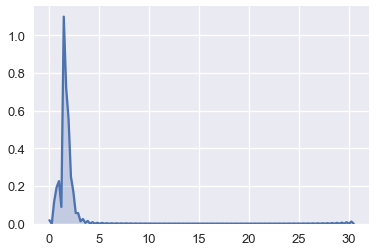

In [11]:
sns.kdeplot(dists,cut=0,shade=True);

We compute a threshold of that is the mean distance plus three standard deviations.

In [12]:
threshold = dists.mean()+3*dists.std()

In [13]:
noise = dists[dists>threshold]
signal = dists[dists<=threshold]
print(noise.size, "points detected with a "
      "mean distance exceeding the global threshold of", threshold)

241 points detected with a mean distance exceeding the global threshold of 3.8176351696701722


Plot the kernel density of only those points whose mean distance falls below the threshold.

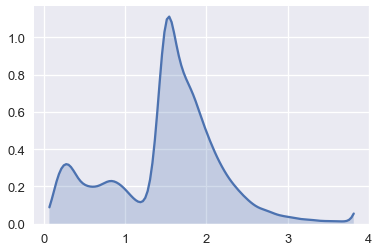

In [14]:
sns.kdeplot(signal,cut=0,shade=True);

### PDAL Pipeline
Now that we've looked at the basic theory, we will look at how to invoke this as part of a pipeline.

#### Assign

Because our data may have other classifications, we will first reset all classifications to 0 with PDAL's `assign` filter. In this context, we only do this so that we may more easily visualize the noise classifications that are generated by the `outlier` filter.

```json
{
  "type":"filters.assign",
  "assignment":"Classification[:]=0"
}
```

#### Outlier

The PDAL outlier filter does most of the work for this operation. We have described above the theory behind the statistical outlier filter, using eight neighbors, and setting the threshold at the global mean plus three standard deviations.

```json
{
  "type": "filters.outlier",
  "method": "statistical",
  "multiplier": 3,
  "mean_k": 8
}
```

In [17]:
json = u'''
{
  "pipeline":[
    {
      "type":"readers.las",
      "filename":"https://github.com/PDAL/data/blob/master/isprs/samp11-utm.laz?raw=true"
    },
    {
      "type":"filters.assign",
      "assignment":"Classification[:]=0"
    },
    {
      "type": "filters.outlier",
      "method": "statistical",
      "multiplier": 3,
      "mean_k": 8
    }
  ]
}'''

Create and execute the new pipeline.

In [18]:
p = pdal.Pipeline(json)
p.validate()
p.loglevel = 8
p.execute()
print(p.log)
data = p.arrays[0]

(pypipeline readers.las Debug) Executing pipeline in standard mode.
(pypipeline filters.outlier Debug) 		Labeled 241 outliers as noise!



In [19]:
json = u'''
{
  "pipeline":[
    {
      "type":"readers.las",
      "filename":"https://github.com/PDAL/data/blob/master/isprs/samp11-utm.laz?raw=true"
    },
    {
      "type":"filters.python",
      "script":"sor.py",
      "function":"sor"
    }
  ]
}'''
p = pdal.Pipeline(json)
p.validate()

True

In [20]:
p.execute()

38010

In [21]:
pd.DataFrame(p.arrays[0]).describe()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId
count,38010.000000,3.801000e+04,38010.000000,38010.000000,38010.0,38010.0,38010.0,38010.0,38010.000000,38010.0,38010.0,38010.0
mean,512767.010570,5.403708e+06,356.171434,0.426835,1.0,1.0,0.0,0.0,1.189608,0.0,0.0,0.0
std,38.570375,8.587360e+01,29.212680,0.494624,0.0,0.0,0.0,0.0,1.089034,0.0,0.0,0.0
min,512700.870000,5.403547e+06,295.250000,0.000000,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,512733.530000,5.403645e+06,329.060000,0.000000,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,512766.940000,5.403705e+06,356.865000,0.000000,1.0,1.0,0.0,0.0,2.000000,0.0,0.0,0.0
75%,512799.900000,5.403790e+06,385.860000,1.000000,1.0,1.0,0.0,0.0,2.000000,0.0,0.0,0.0
max,512834.760000,5.403850e+06,404.080000,1.000000,1.0,1.0,0.0,0.0,7.000000,0.0,0.0,0.0


In [22]:
cc = pd.DataFrame(p.arrays[0],columns=['Classification'])

In [23]:
len(cc[cc['Classification']==7])

241